# Análisis de Sentimiento sobre Tweets
La idea general de este notebook es realizar un análisis de sentimiento sobre un dataset de tweets. Se dividirá en el paso a paso hasta llegar al objetivo final de poder obtener un modelo que prediga la polaridad.  
El dataset utilizado proviene de datos de [Sentiment 140](http://help.sentiment140.com/for-students), y puede encontrarse en el siguiente link:  
https://docs.google.com/file/d/0B04GJPshIjmPRnZManQwWEdTZjg/edit

## Carga, Pre-visualización, y Almacenamiento de los datos crudos

### Inicializo Spark  
Viendo el dataset que descargué, y sabiendo que es un dataset relativamente voluminoso (200 MB), modifiqué la memoria para que los workers pudiesen tener un poco más de potencia. Igualmente, en caso de estar consumiendo datos de una fuente real en vivo, podrían modificarse las especificaciones como así también la cantidad de workers para que se adapten al proceso "normal".

In [1]:
import findspark
findspark.add_jars('/app/postgresql-42.1.4.jar')
findspark.init()

In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("twitter-sentiment")
    .config("spark.driver.memory", "1024m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "1024m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.5")
    .getOrCreate()
)

### Genero el esquema de la tabla  
Desde el sitio de descarga nos brindan una descripción del formato en que viene la información, por lo que se aprovecha esa información para generar el esquema de la tabla cruda. El campo ```date``` que tiene información sobre la fecha, inicialmente será considerado como ```StringType```, aunque en posteriores secciones de limpieza y procesamiento pueda llegar a ser transformado.

In [3]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType #, TimestampType, DateType
 
#polarity: la polaridad del tweet (0 = negativa, 2 = neutral, 4 = positiva)
#id: el id del tweet (2087)
#date: la fecha del tweet (Sat May 16 23:58:44 UTC 2009)
#query: el query (lyx). En caso de no existir, su valor es NO_QUERY.
#user: el usuario del tweet (robotickilldozr)
#content: el contenido del tweet (Lyx is cool)
 
schema = StructType([StructField('polarity', IntegerType(), True),
                     StructField('id', IntegerType(), True),
                     StructField('date', StringType(), True),
                     StructField('query', StringType(), True),
                     StructField('user', StringType(), True),
                     StructField('content', StringType(), True)])

### Cargo los datos en un dataframe  
Se guarda el dataset completo en ```df_raw```. Queda comentado aquí también la carga del segundo set de datos más pequeños y de prueba que también brindaba el sitio utilizado.

In [5]:
from pyspark.sql import functions as F
 
df_raw = spark.read.options(header=False,delimiter=',').schema(schema).csv('/dataset/tweets/training.1600000.processed.noemoticon.csv').repartition(16).cache()
#df_raw = spark.read.options(header=False,delimiter=',').schema(schema).csv('/dataset/tweets/testdata.manual.2009.06.14.csv').repartition(16).cache()

### Visualización del dataframe  
Aunque ya hayamos generado el esquema según el proveedor del set de datos, nunca está de más hacer una pequeña visualización de la pinta que tienen, ya sea para detectar posibles errores en el procesamiento, o para entender que transformaciones pueden llegar a ser necesarias.  
  
En este caso, podemos observar los siguientes puntos:  
- ```polarity``` que es el que nos interesaría predecir parecería ser categórico  
- ```id``` es numérico
- ```date``` viene en un formato "poco amigable"
- ```query``` no parecería aportar mucha información
- ```user``` permite el uso de todo tipo de caracter
- ```content``` permite todo tipo de caracter y probablemente es de donde podamos obtener más información

In [6]:
df_raw.show(10)

+--------+----------+--------------------+--------+------------+--------------------+
|polarity|        id|                date|   query|        user|             content|
+--------+----------+--------------------+--------+------------+--------------------+
|       0|2067081929|Sun Jun 07 11:42:...|NO_QUERY|   lar103081|Why when I get a ...|
|       0|2048939566|Fri Jun 05 16:01:...|NO_QUERY|     jacqpow|Wish I was in atl...|
|       0|2053378891|Sat Jun 06 04:20:...|NO_QUERY|  HappyBoy11|Loved the party w...|
|       0|1979694636|Sun May 31 04:07:...|NO_QUERY|SongoftheOss|@SapphyNo1 oh no,...|
|       0|1989769985|Mon Jun 01 02:44:...|NO_QUERY|   TriaKayli|puked  by far the...|
|       0|1989144112|Mon Jun 01 00:29:...|NO_QUERY|    timseawa|@MsAsHleY33  I wa...|
|       0|1963175187|Fri May 29 12:19:...|NO_QUERY|theclarkster|So tonights TV vi...|
|       0|1881095385|Fri May 22 03:35:...|NO_QUERY|  JacThomson|@stephenfry I can...|
|       0|1551044479|Sat Apr 18 07:59:...|NO_QUERY| x_

### Visualización del Esquema  
Este punto lo realizamos para validar que hayamos cargado bien el ```schema```.

In [7]:
df_raw.printSchema()

root
 |-- polarity: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- user: string (nullable = true)
 |-- content: string (nullable = true)



### Cantidad de registros por cada clase a predecir  
Para validar si realmente ```polarity``` es categórica, realizamos un recuento de los registros para cada categoría. Además, nos permitirá conocer si las clases están muy desbalanceadas para tomar alguna acción al respecto.  
  
Viendo los resultados, en principio podemos concluir que ```polarity``` no viene como categórica (0 y 1), y deberemos realizarle alguna transformación, que contiene valores ```null```, que podrían atribuirse a datos sin clasificar, datos incompletos, o errores de datos, y que ```polarity = 4``` contiene bastantes más registros (Twitter suele ser una plataforma donde los usuarios discuten y son negativos).

In [8]:
df_raw.groupBy('polarity').count().show()

+--------+------+
|polarity| count|
+--------+------+
|       4|706287|
|    null|432913|
|       0|460800|
+--------+------+



### Estadísticas generales  
Aprovehcamos el comando ```describe()``` para tener mayor descripción sobre los contenidos de cada campo.  
  
En nuestro caso, lo único que se confirma aquí es el desbalanceo de clases, y que hay 1167087 registros no nulos.

In [9]:
df_raw.describe().show()

+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|summary|          polarity|                  id|                date|   query|                user|             content|
+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|  count|           1167087|             1167087|             1167087| 1167087|             1167087|             1167087|
|   mean|2.4206832909628844|1.9151683893187106E9|                null|    null| 4.227947099985646E9|                null|
| stddev|1.9552567208441742|1.5759017606746882E8|                null|    null|5.670585608531951E10|                null|
|    min|                 0|          1467810369|Fri Apr 17 20:30:...|NO_QUERY|        000catnap000|                 ...|
|    max|                 4|          2072532109|Wed May 27 07:27:...|NO_QUERY|     zzzyourdreamzzz|�����ߧ�ǿ�����ж�؜�...|
+-------+---------------

### Guardo la tabla en Postgres  
Luego de obtener y realizar esa visualización inicial de los datos, lo primero que haremos es guardarlos sin modificar en una tabla de Postgres, como para no alterar esa versión original.

In [10]:
df_raw \
    .write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres/workshop") \
    .option("dbtable", "workshop.tweets_raw") \
    .option("user", "workshop") \
    .option("password", "w0rkzh0p") \
    .option("driver", "org.postgresql.Driver") \
    .mode('overwrite') \
    .save()

### Levanto dataframe desde Postgres  
Para validar que la tabla se ha guardado correctamente, y para trabajar sobre una copia de los datos y no sobre los originales, vuelvo a cargar la tabla.

In [11]:
df_raw= spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres/workshop") \
    .option("dbtable", "workshop.tweets_raw") \
    .option("user", "workshop") \
    .option("password", "w0rkzh0p") \
    .option("driver", "org.postgresql.Driver") \
    .load()

Realizo un recuento de los registros, y veo correctamente que el número total de registros es 1600000.

In [12]:
df_raw.count()

1600000

Como anteriormente había observado que esos datos contenían datos nulos, los filtro para trabajar únicamente con datos útiles.

In [13]:
from pyspark.sql.functions import col, isnull

df_filtered = df_raw.filter(~isnull(col("polarity")) & ~isnull(col("date")))

Realizando un recuento, observo que el número de registros coincide con lo que había analizado.

In [14]:
df_filtered.count()

1167087

## Análisis de los datos  
En esta sección, el objetivo será realizar algunas visualizaciones para intentar obtener insights que ayuden en la decisión de como armar nuestros modelos y que campos tomar.  
  
Comienzo por realizar una transformación de ```date``` a un formato que me permita realizar algún gráfico de evolución en el tiempo.

In [15]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, date_format

# Transformo fecha en formato amigable
df_filtered = df_filtered.withColumn("date", date_format(from_unixtime(unix_timestamp("date", "EEE MMM dd HH:mm:ss z yyyy")), "yyyy-MM-dd"))

Por cuestiones de practicidad y tiempos al momento de procesar los gráficos y posteriores transformaciones sobre los datos, estaré utilizando una porción de los datos que permite entender cómo funcionaría el resto del pipeline, pero obviamente los números y resultados podrían ser distintos.  Nuevamente, la idea de este notebook no es dejar una aplicación funcional, sino diagramar un esqueleto que podría ser escalable por tratarse de procesamiento distribuido.

In [16]:
import random

# Sampleo el 1% de datos de forma aleatoria
random.seed(35377289)
df_sampled = df_filtered.sample(False, 0.01, seed=35377289)

In [17]:
df_sampled.count()

11647

Convierto el dataframe de Spark a Pandas para poder utilizar varias librerías de gráficos.

In [18]:
# Conierto Dataframe Spark en Pandas
df_pandas = df_sampled.toPandas()

### Visualización del largo por cada categoría  
Podría darse el caso de que la longitud del tweet (cantidad de palabras) influya sustancialmente en su clasificación, por lo que realizo un gráfico de tipo "violin".  
  
En este caso, concluyo que el largo no parecería tener un impacto considerable en su clasificación, aunque los tweets positivos (0) tienen algo más de concentración que los negativos (4) mientras más largos son.

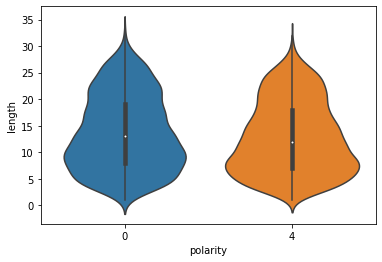

In [19]:
import seaborn as sns

df_pandas['length']= df_pandas['content'].str.split().map(lambda x: len(x))

ax = sns.violinplot(x='polarity', y='length', data=df_pandas)

Chequeo nuevamente el desbalanceo de clases para confirmar que siguen habiendo más tweets negativos.

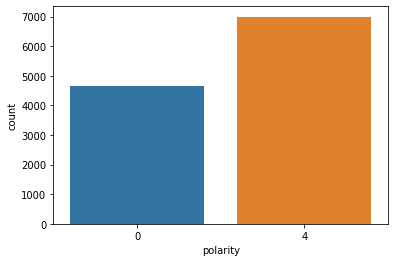

In [20]:
import matplotlib.pyplot as plt

sns.countplot(x='polarity', data=df_pandas)
plt.show()

### Visualización de las palabras asociadas a tweets positivos  
Luego, intento ver qué palabras están más asociadas a una y otra clasificación, para confirmar que el contenido de las palabras sea realmente lo que importa en un tweet.  
  
Comienzo por instalar lo necesario para realizar una nube de palabras.

In [21]:
!apt-get update && apt-get install -y python3-pip

Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://security.debian.org/debian-security buster/updates InRelease [34.8 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Get:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [430 kB]
Get:5 http://deb.debian.org/debian buster/main amd64 Packages [7909 kB]
Get:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [8788 B]
Fetched 8561 kB in 7s (1205 kB/s)                                              
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-pip is already the newest version (18.1-5).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


In [22]:
!python3 -m pip install --upgrade pip
!python3 -m pip install --upgrade Pillow
!python -m pip install wordcloud

    100% |████████████████████████████████| 2.1MB 252kB/s ta 0:00:01
  Found existing installation: pip 18.1
    Not uninstalling pip at /usr/lib/python3/dist-packages, outside environment /usr
    Can't uninstall 'pip'. No files were found to uninstall.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 kB 987.2 kB/s eta 0:00:0000:0100:01


Como uno imaginaría, dentro de los tweets positivos, las palabras más repetidas son las que solemos asociar con ese sentimiento, como "good", "love", o "thank". Es importante remarcar que tanto para este gráfico como para procesamientos posteriores, hay algunas palabras que no aportan y ensucian la información como lo son las ```stopwords```.

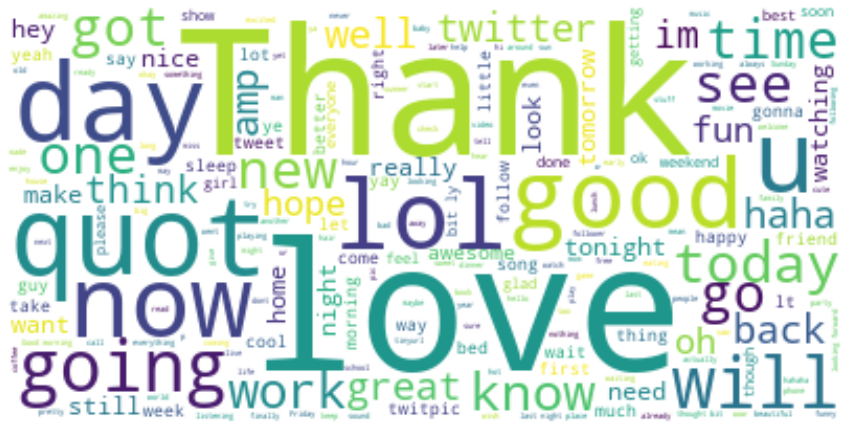

In [23]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import pandas as pd
 
pos = df_pandas[df_pandas['polarity'] == 4]
content = " ".join(i for i in pos.content)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(content)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Visualización de las palabras asociadas a tweets negativos  
Aquí en cambio, es interesante remarcar que no solamente vemos palabras que nos imaginaríamos como "sad", "miss" o "sorry", sino que encontramos también palabras que figuraban como positivas, como el caso de "love", que podría tener ambos significados. Son esos casos los que hacen que las palabras por separado no sean excelentes indicadores de predicción para clasificar sentimiento, y que los niveles de accuracy no lleguen a ser tan elevados como con otros modelos.

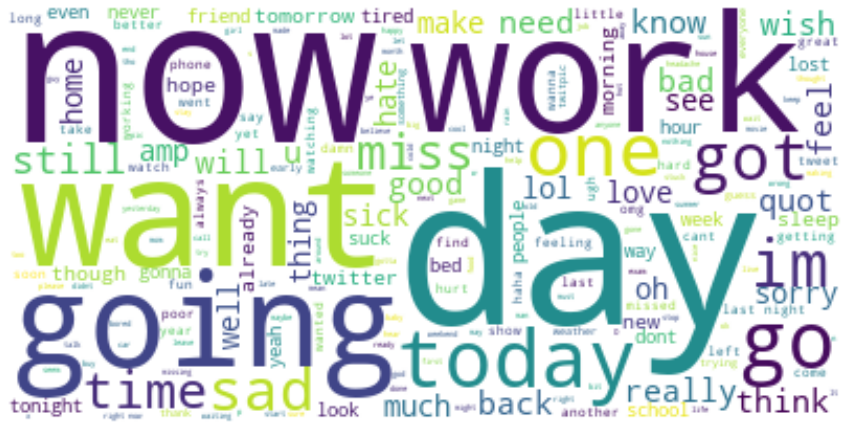

In [24]:
neg = df_pandas[df_pandas['polarity'] == 0]
content = " ".join(i for i in neg.content)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(content)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Evolución de tweets en el tiempo  
Para ver si el tiempo tiene influencia en la clasificación del sentimiento, se realiza un gráfico de evolución de ambas categorías.  
  
Se comienza por agrupar los tweets por día y ordenar los datos.

In [25]:
from pyspark.sql.functions import count

# Agrupo y cuento tweets
df_polarity_count = df_sampled.groupBy("date").pivot("polarity").agg(count("*").alias("count")).orderBy("date", ascending=True)
df_polarity_count.show()

+----------+----+---+
|      date|   0|  4|
+----------+----+---+
|2009-04-07|  90|125|
|2009-04-18|  67|106|
|2009-04-19| 121|181|
|2009-04-20|  68| 90|
|2009-04-21|  46| 61|
|2009-05-02| 148|169|
|2009-05-03| 105|155|
|2009-05-04| 111|167|
|2009-05-10| 128|177|
|2009-05-11|  25| 33|
|2009-05-12|  14| 23|
|2009-05-14|  77|125|
|2009-05-17| 154|255|
|2009-05-18| 170|271|
|2009-05-22| 149|267|
|2009-05-24|   1|  1|
|2009-05-25|null|  5|
|2009-05-27|  55| 54|
|2009-05-29| 255|371|
|2009-05-30| 400|631|
+----------+----+---+
only showing top 20 rows



Del gráfico, se concluye que aunque existe una variación en la cantidad de tweets que hay por día, la composición entre las categorías parecería mantenerse estable. Por ello, aunque seguramente para algunas fechas importantes como podrían ser navidad o el día de los enamorados, podría haber influencia de la fecha en la clasificación del tweet, no la tomaremos como posible predictor.

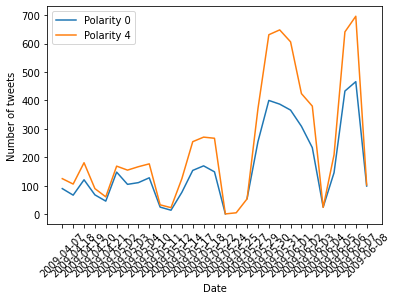

In [26]:
import matplotlib.pyplot as plt

# Extract the columns for polarity 0 and 4
polarity_0 = df_polarity_count.select('date', '0').toPandas()
polarity_4 = df_polarity_count.select('date', '4').toPandas()

# Create the line chart
plt.xticks(rotation=45)
plt.plot(polarity_0['date'], polarity_0['0'], label='Polarity 0')
plt.plot(polarity_4['date'], polarity_4['4'], label='Polarity 4')
plt.xlabel('Date')
plt.ylabel('Number of tweets')
plt.legend()
plt.show()

## Preprocesamiento
Habiendo entendido mejor nuestro set de datos, se decide únicamente tomar la columna de ```content``` como predictora para nuestros modelos. Obviamente las columnas ```date```, ```query```, y ```user``` probablemente ayudarían a mejorar el modelo en caso de procesarlas e incluírlas, pero considerando que estaremos utilizando un sampleo de la data total, es posible que la mejora sea marginal por sobre el trabajo adicional que llevaría utilizarlas.  
  
### Selección de datos a utilizar
Se comienza entonces por dropear esas columnas y aprovechar para renombrar ```polarity``` como ```category```, que suele ser el nombre más comunmente utilizado para las variables a predecir.

In [27]:
df = df_sampled. \
    withColumnRenamed("polarity", "category"). \
    drop('id'). \
    drop('date'). \
    drop('query'). \
    drop('user'). \
    cache()

### Filtrado de columna de contenido
Estaremos aprovechando la librería ```gensim``` con filtros utilizados generalmente para el procesamiento de texto, buscando limpiar lo más posible el contenido de los tweets. Es interesante que para el caso de los tweets, pueden llegar a haber caracteres o formas de escribir que podríamos no tener que eliminar, pero al menos para este análisis en particular, estaremos intentando hacer foco solamente en las palabras.

In [28]:
import gensim.parsing.preprocessing as gsp
from gensim import utils

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

También aprovechamos esta ```UDF``` para normalizar el texto (mayúsculas, formato, y aplicar los flitros establecidos).

In [29]:
# Preprocessing UDF
# https://changhsinlee.com/pyspark-udf/

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def clean_text(x):
    s = x.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

clean_text_udf = udf(lambda text: clean_text(text), StringType())

Aplico la ```UDF``` a la columna con el contenido del tweet y dropeo la columna con el contenido original.

In [31]:
df_processed = df_processed.withColumn('text', clean_text_udf(df.content)).drop('content')

### División en Training y Testing
Para dividir en Training y Testing, se agrega una columna ```train``` que toma los valores de ```True``` o ```False``` aleatoriamente según la semilla y tamaño de muestra establecidos.

In [30]:
# División en Training y Testing
SEED=35377289
TEST_SIZE=0.2

from pyspark.sql.functions import rand, when
df_processed = df.withColumn('train', when(rand(seed=SEED) >= TEST_SIZE, True).otherwise(False))

### Visualización pre-entrenamiento
Visualizamos el dataset procesado, que esta mucho más limpio para entrenar cualquier modelo. Restaría procesar la columna ```text``` para poder dividir las palabras y tomarlas como features.

In [32]:
df_processed.show()

+--------+-----+--------------------+
|category|train|                text|
+--------+-----+--------------------+
|       0|false|rip tweet geniu k...|
|       0|false|stuck go job good...|
|       4| true|walk sunris dai c...|
|       4| true|watch whitnei mis...|
|       4| true|got site host giv...|
|       0| true|         suck pinbal|
|       0| true|didnt camp job fr...|
|       0| true| damn earli tomorrow|
|       4|false|marinealwai wait ...|
|       4|false|yelyahwilliam fes...|
|       4| true|msmccoi thank mam...|
|       4| true|           psh watch|
|       4| true|erinsk want detai...|
|       4| true| premedit sleep sofa|
|       4| true|go run string lig...|
|       0| true|btcc vaulkhard pu...|
|       0|false|            want pho|
|       0| true|eat appl danish e...|
|       0|false|search photograph...|
|       0| true|thing good awesom...|
+--------+-----+--------------------+
only showing top 20 rows



## Entrenamiento de Modelos
Siendo el procesamiento del lenguaje natural un tema altamente complejo, en nuestro pipeline estaremos cubriendo algunos posibles modelos básicos. Como continuamos trabajando con un sampleo de los datos, los números obtenidos deben servir solamente para orientarnos y no para obtener conclusiones definitivas. Además, con el fin de poder realizar múltiples corridas de prueba, no se buscarán optimizar los hiperparámetros de cada uno de los modelos, aunque sí se mencionarán, y podrían optimizarse con la utilización de algoritmos como ```grid search``` o ```bayesian optimization```.

### Armado del Pipeline para los entrenamientos
En este paso, vamos a pasar la variable ```category``` para que sea categórica con ```StringIndexer```, generar "tokens" a partir del texto (es decir, dividir todo el texto por palabras) con ```Tokenizer```, y pasarlas a features con ```Word2Vec```. Aunque este procesamiento es sencillo, suele utilizarse algo similar (aunque con más optimizaciones y filtros) en la mayoría de los procesamientos de lenguaje natural. Para el caso de ```Word2Vec```, se estableció un ```minCount=5``` para que no se le de tanta importancia a palabras que no figuren tantas veces.

In [33]:
%%time
import pyspark.sql.functions as f
from pyspark.ml.feature import Word2Vec, Tokenizer, StringIndexer
from pyspark.ml import Pipeline

# Creo String Indexer
str_indexer = StringIndexer(inputCol="category", outputCol="label")

# Creo Tokens
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
word2vec = Word2Vec(vectorSize=100, minCount=5, inputCol="tokens", outputCol="features")

# Creo Pipeline
pipeline = Pipeline(stages=[str_indexer, tokenizer, word2vec])
model = pipeline.fit(df_processed)

# Transformo Dataframe
df_w2v = model.transform(df_processed)

# Muestro Resultados
df_w2v.show()

+--------+-----+--------------------+-----+--------------------+--------------------+
|category|train|                text|label|              tokens|            features|
+--------+-----+--------------------+-----+--------------------+--------------------+
|       0|false|rip tweet geniu k...|  1.0|[rip, tweet, geni...|[-0.0020490206079...|
|       0|false|stuck go job good...|  1.0|[stuck, go, job, ...|[-0.0015451268215...|
|       4| true|walk sunris dai c...|  0.0|[walk, sunris, da...|[0.01050625475666...|
|       4| true|watch whitnei mis...|  0.0|[watch, whitnei, ...|[-0.0982937298715...|
|       4| true|got site host giv...|  0.0|[got, site, host,...|[0.00270008708078...|
|       0| true|         suck pinbal|  1.0|      [suck, pinbal]|[-2.0863322424702...|
|       0| true|didnt camp job fr...|  1.0|[didnt, camp, job...|[-0.0165757234208...|
|       0| true| damn earli tomorrow|  1.0|[damn, earli, tom...|[0.01354025738934...|
|       4|false|marinealwai wait ...|  0.0|[marinealwa

Visualizando la salida, ahora sí este set de datos ya tiene el formato al que estamos acostumbrados para comenzar a entrenar los modelos.

### División en Training y Testing
Habiendo realizado todas las transformaciones de datos necesarias, ahora finalmente utilizamos el campo ```train``` para dividir en ```df_train``` y ```df_test```.

In [34]:
df_train = df_w2v.filter(f.col('train') == True)
df_test = df_w2v.filter(f.col('train') == False)

Aunque los modelos más utilizados para el procesamiento del lenguaje natural son las redes neuronales (Recurrent Neural Networks, Convolutional Neural Networks y LSTM Neural Networks), para evitar posibles conflictos con otras librerías del ambiente, reducir tiempos de entrenamiento (las redes neuronales demoran por el BackPropagation), y aprovechar principalmente la librería de ```pyspark.ml```, se estarán entrenando y comparando: Logistic Regression, Random Forest y Support Vector Machine.

### Logistic Regression
La ```LogisticRegression``` sirve para predecir un outcome que en nuestro caso es binario, pero podría ser multiclase, a partir de una combinación lineal de features. Es un algoritmo simple y tiene la ventaja de poder explicarse con relativa facilidad frente al resto de los algoritmos.  
  
Entre los parámetros encontramos:  
- ```regParam```, agrega una penalización a la función de pérdida y se utiliza para reducir el overfitting.  
- ```elasticNetParam```, indica la mezcla de regulaziadores que se utiliza entre Lasso y Ridge.  
- ```maxIter```, es el número de iteraciones.  
- ```tol```, limita la finalización del algoritmo cuando la diferencia entre la nueva solución y la previa es menor al parámetro.  
- ```fitIntercept```, es un flag para indicar si utilizar o no un intercept.
- ```aggregationDepth```, aumenta la profundidad de agregación del árbol, pero también la exigencia computacional.  
  
No estaremos modificando los seteos default de ninguno de estos parámetros.

In [35]:
%%time
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Logistic Regression
lr = LogisticRegression(labelCol="label", featuresCol="features")
lr_pipeline = Pipeline(stages=[lr])
lr_model = lr_pipeline.fit(df_train)
lr_predictions = lr_model.transform(df_test)
lr_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lr_accuracy = lr_evaluator.evaluate(lr_predictions)
print("Logistic Regression Accuracy: {}".format(lr_accuracy))

Logistic Regression Accuracy: 0.6475898644226274
CPU times: user 122 ms, sys: 89.2 ms, total: 211 ms
Wall time: 32.2 s


Una precisión del 65% para un algoritmo tan sencillo, sin optimizar, tomando un sampleo del total de los datos, y considerando la complejidad del problema, es más que aceptable

### Random Forest
```RandomForestClassifier``` es un algoritmo de tipo árbol de decisión, que suelen ser bastante utilizados para las clasificaciones en general, por su buena performance vs. costo computacional, aunque pierde un poco su explicabilidad mientras más cantidad de árboles se generen.  
  
Los parámetros que podemos modificar son:  
- ```numTrees```, número de árboles que se generan.
- ```maxDepth```, profundidad de los árboles.
- ```impurity```, criterio utilizado como función de ganancia.
- ```featureSubsetStrategy```, número de features a considerar en cada split.
- ```minInstancesPerNode```, mínimo número de hojas que debe tener un nuevo nodo.
- ```subsamplingRate```, fracción del set de datos que debe tomar cada árbol para su entrenamiento.  
  
Para este caso modificamos el número de árboles y su profundidad, con el fin de brindar predicciones un poco más precisas.

In [36]:
%%time

# Random Forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees = 100, maxDepth = 20)
rf_pipeline = Pipeline(stages=[rf])
rf_model = rf_pipeline.fit(df_train)
rf_predictions = rf_model.transform(df_test)
rf_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print("Random Forest Accuracy: {}".format(rf_accuracy))

Random Forest Accuracy: 0.6066233461440951
CPU times: user 82.4 ms, sys: 47.5 ms, total: 130 ms
Wall time: 2min 38s


Aunque en general ```Random Forest``` suele superar a ```Logistic Regression```, hemos obtenido una precisión menor del 60%, que se debe a no optimizar el resto de los parámetros.

### Support Vector Machine
```LinearSVC``` es la versión de una Support Vector Machine con la que cuenta esta librería, y podemos aplicar a nuestro caso porque la categoría de predicción tiene solamente 2 posible valores. Este tipo de algoritmo busca elevar el problema de dimensión, y en esa nueva dimensión intenta establecer un corte sobre los datos que mejor permita clasificar las categorías. Aunque se puede simplificar su funcionamiento como ocurre con ```RandomForestClassifier```, no deja de tener menos explicabilidad que una ```LinearRegression```.  
  
Los parámetros que podemos optimizar son:
- ```maxIter```, número de iteraciones.
- ```regParam```, para la regularización.
- ```tol```, tolerancia para frenar el algoritmo.
- ```weightCol```, nombre de la columna con peso (en caso de haberlo).  
  
Para nuestro caso, fijaremos el número de iteraciones para no dejar corriendo el algoritmo excesivamente, pero obtener una predicción con sentido.

In [37]:
%%time
# SVM
svm = LinearSVC(labelCol="label", featuresCol="features", maxIter=100)
svm_pipeline = Pipeline(stages=[svm])
svm_model = svm_pipeline.fit(df_train)
svm_predictions = svm_model.transform(df_test)
svm_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
svm_accuracy = svm_evaluator.evaluate(svm_predictions)
print("SVM Accuracy: {}".format(svm_accuracy))

SVM Accuracy: 0.45052998358196616
CPU times: user 77.2 ms, sys: 99.8 ms, total: 177 ms
Wall time: 7min 59s


Hemos obtenido una precisión mucho peor ```LogisticRegression``` (incluso peor que el "random"), lo que no quiere decir necesariamente que el algoritmo sea "peor", sino que habría que buscar optimizar los hiperparámetros, aunque es verdad que tal vez sería mejor una Support Vector Machine sobre la que pudieramos cambiar el ```kernel```. 
  
Por otro lado, como ```RandomForestClassifier``` suele funcionar mejor que una Regresión Logística para este tipo de problemas, atribuiremos la diferencia también a falta de optimización de hiperparámetros y porción del dataset utilizado.
  
Finalmente imprimimos las predicciones de uno de los modelos para ver cómo nos devuelven los resultados.

In [44]:
rf_predictions.show()

+--------+-----+--------------------+-----+--------------------+--------------------+--------------------+----------+
|category|train|                text|label|              tokens|            features|       rawPrediction|prediction|
+--------+-----+--------------------+-----+--------------------+--------------------+--------------------+----------+
|       0|false|rip tweet geniu k...|  1.0|[rip, tweet, geni...|-0.00204902060795...|67.00414224991279...|       0.0|
|       0|false|stuck go job good...|  1.0|[stuck, go, job, ...|-0.00154512682153...|53.73144853074992...|       0.0|
|       4|false|marinealwai wait ...|  0.0|[marinealwai, wai...|1.687346957623958...|57.6241296687117 ...|       0.0|
|       4|false|yelyahwilliam fes...|  0.0|[yelyahwilliam, f...|-0.01318454826832...|69.14372127143804...|       0.0|
|       0|false|            want pho|  1.0|         [want, pho]|-0.00023198610870...|31.04738955823293...|       1.0|
|       0|false|search photograph...|  1.0|[search, phot

Veo el schema que tiene la tabla para crearla previamente en Postgres

In [46]:
rf_predictions.printSchema()

root
 |-- category: integer (nullable = true)
 |-- train: boolean (nullable = false)
 |-- text: string (nullable = true)
 |-- label: double (nullable = false)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: string (nullable = true)
 |-- rawPrediction: string (nullable = true)
 |-- prediction: double (nullable = false)



### Guardo Resultados en Postgres
Obviamente el objetivo de realizar una predicción es poder utilizar esos resultados con algún fin, y por ello es importante guardar las predicciones. Aunque en este caso hayamos utilizado el método de ```transform``` sobre ```df_test``` y en la realidad usemos el método ```predict``` sobre datos desconocidos, sirve a efectos de terminar de formar al esqueleto que hemos desarrollado.  
  
Antes de guardarla, modifico su formato para poder adaptarme al esquema armado en Postgres.

In [42]:
from pyspark.sql.functions import UserDefinedFunction, udf
from pyspark.ml.linalg import VectorUDT

def convert_vector(v):
    return " ".join(str(x) for x in v)

convert_vector_udf = udf(convert_vector, StringType())

rf_predictions = rf_predictions.select(
  "category", 
  "train", 
  "text", 
  "label", 
  "tokens", 
  convert_vector_udf("features").alias("features"), 
  convert_vector_udf("rawPrediction").alias("rawPrediction"), 
  "prediction"
)

Finalmente guardo las predicciones de uno de los modelos, para disponibilizar su uso.

In [43]:
rf_predictions \
    .write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres/workshop") \
    .option("dbtable", "workshop.tweets_predictions") \
    .option("user", "workshop") \
    .option("password", "w0rkzh0p") \
    .option("driver", "org.postgresql.Driver") \
    .mode('overwrite') \
    .save()

Es importante aclarar que en caso de querer establecer un verdadero modelo que clasifique la polaridad de tweets, es probable que se utilicen distintos modelos combinados/stackeados.

## Simulación de Streaming
Como último paso, se debería aplicar el modelo entrenado seleccionado a data real para poder clasificar en tiempo real lo que está ocurriendo. Aquí estaré simulando la entrada de data ficticia a partir de una parte de los datos del dataset original, la cual será leída en forma de stream, procesada, y guardada en formato parquet. No utilizaré Kafka por dificultades de compatibilidad con las versiones, y otros errores que surgieron.  

### Establecer directorios
Comienzo por establecer los directorios que estaré utilizando.

In [47]:
input_dir = '/dataset/stream_input'
output_dir = '/dataset/stream_output'
checkpoint = '/dataset/checkpoint'

### Selección de datos para el stream
Tomo una porción de los datos para simular.

In [48]:
random.seed(35377289)
df_stream = df_filtered.sample(False, 0.1, seed=35377289)

Limito la cantidad de datos para completar la prueba.

In [49]:
df_stream = df_stream.limit(10)

In [50]:
df_stream.show()

+--------+----------+----------+--------+--------------+--------------------+
|polarity|        id|      date|   query|          user|             content|
+--------+----------+----------+--------+--------------+--------------------+
|       4|2046754616|2009-06-05|NO_QUERY|   PinchedPink|Wondering when I'...|
|       4|1833842481|2009-05-18|NO_QUERY|   SomersetBob|@IvyBean104 Good ...|
|       4|2065869087|2009-06-07|NO_QUERY|imlikelemonade|@dougiemcfly http...|
|       4|1990123256|2009-06-01|NO_QUERY|  coopercakess|juss cussed out s...|
|       4|2006599704|2009-06-02|NO_QUERY|    Mz_Farrari|@SedAtl20 awww th...|
|       4|1974756762|2009-05-30|NO_QUERY|MCRsavedMilife|@xXMCR_LadyXx bet...|
|       0|2067081929|2009-06-07|NO_QUERY|     lar103081|Why when I get a ...|
|       0|1957359317|2009-05-29|NO_QUERY|     iwishiwas|Holy shit it's su...|
|       0|2048072334|2009-06-05|NO_QUERY|ACGdreamgirl08|RIP Tweet Genius....|
|       0|1557060593|2009-04-19|NO_QUERY|       emoly28|@Stefffl

### Procesamiento y guardado del stream
Establezco el ```schema``` que utilizaré para guardar y leer los datos parquet.  
  
Además, genero una función que busca replicar las transformaciones de limpieza realizados previos al entrenamiento de los modelos.

In [51]:
from pyspark.sql.functions import *
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.types import DateType
schema_stream = StructType([StructField('polarity', IntegerType(), True),
                     StructField('id', IntegerType(), True),
                     StructField('query', StringType(), True),
                     StructField('user', StringType(), True),
                     StructField('content', StringType(), True),
                     StructField('date', DateType(), True),])

def transform_df(df: DataFrame) -> DataFrame:
  # Your transformation function here, this function should transform a normal dataframe to another normal dataframe
    df = df.withColumnRenamed('polarity', 'category').drop('id').drop('date').drop('query').drop('user')
    df = df.withColumn('text', clean_text_udf(df.content)).drop('content')
    df = model.transform(df)
    return df

Guardo el stream de datos en formato parquet.

In [52]:
# Save dataframe to parquet format
df_stream \
    .write \
    .mode('overwrite') \
    .parquet(input_dir)

Creo el stream de datos que lee sobre el parquet.

In [53]:
# Read parquet file as a stream
streaming_df = (spark
                .readStream
                .format("parquet")
                .option("path", input_dir)
                .schema(schema_stream)
                .load())

Aplico transformaciones.

In [54]:
# Apply transform_df to the stream
transformed_stream = transform_df(streaming_df)

Realizo las predicciones.

In [55]:
# Make predictions using the linear regression model
prediction = lr_model.transform(transformed_stream)

Guardo el stream de datos procesado en la ubicación de salida como parquet, limitando la corrida a 20 segundos.

In [57]:
query = (prediction
         .writeStream
         .format('parquet')
         .outputMode('append')
         .option('path', output_dir)
         .option('checkpointLocation', checkpoint)
         .start())

query.awaitTermination(timeout=20)

False

Agrego opción para frenar manualmente.

In [58]:
query.stop()

### Verificación de corrida del proceso
Leo desde el directorio de salida para ver que se hayan guardado correctamente los registros.

In [59]:
df_written = spark.read.parquet(output_dir)
df_written.count()

10

In [60]:
df_written.show()

+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|category|                text|label|              tokens|            features|       rawPrediction|         probability|prediction|
+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|       4|wonder stop hold ...|  0.0|[wonder, stop, ho...|[-0.0094601788025...|[-0.7046937818045...|[0.33077237878547...|       1.0|
|       4|ivybean good morn...|  0.0|[ivybean, good, m...|[0.01398805523058...|[1.02820085515104...|[0.73656694543275...|       0.0|
|       4|dougiemcfli http ...|  0.0|[dougiemcfli, htt...|[-0.1254921953222...|[1.53126711333417...|[0.82219163237774...|       0.0|
|       4|juss cuss bitch m...|  0.0|[juss, cuss, bitc...|[-0.0043794126249...|[0.53058203808950...|[0.62961885287734...|       0.0|
|       4|   sedatl awww thank|  0.0|[sedatl, awww, th...|[-0.0092023

Esta es una versión simplificada de lo que sería trabajar con un stream de datos, pero sirve como esquema para comprender los pasos que deberían realizarse, aunque las transformaciones y elementos utilizados como intermediarios varían sustancialmente.

### Finalizo Spark

In [61]:
spark.stop()